# Positive vs. Negative Sentiment Classification

Here we demonstrate how to explain a sentiment classification model for movie reviews. positive vs. negative sentim

In [ ]:
import transformers
import datasets
import shap
import numpy as np

## Load the IMDB movie review dataset

In [ ]:
dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit into the pipeline model
short_data = [v[:500] for v in dataset["text"][:20]]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


## Load and run a sentiment analysis pipeline

In [ ]:
classifier = transformers.pipeline('sentiment-analysis', return_all_scores=True)
classifier(short_data[:2])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


[[{'label': 'NEGATIVE', 'score': 0.07582065463066101},
  {'label': 'POSITIVE', 'score': 0.9241793751716614}],
 [{'label': 'NEGATIVE', 'score': 0.01834249496459961},
  {'label': 'POSITIVE', 'score': 0.9816575050354004}]]

## Explain the sentiment analysis pipeline

In [ ]:
# define the explainer
explainer = shap.Explainer(classifier)

In [ ]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:2])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [01:56, 58.37s/it]               


In [ ]:
shap.plots.text(shap_values[:,:,"POSITIVE"])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Wrap the pipeline manually

SHAP requires tensor outputs from the classifier, and explanations works best in additive spaces so we transform the probabilities into logit values (information values instead of probabilites).

### Create a TransformersPipeline wrapper

In [ ]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=False)

In [ ]:
pmodel(short_data[:2])

array([[0.07582065, 0.92417938],
       [0.01834249, 0.98165751]])

In [ ]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
pmodel(short_data[:2])

array([[-2.50053541,  2.50053583],
       [-3.98002198,  3.98002198]])

In [ ]:
explainer2 = shap.Explainer(pmodel)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [01:53, 56.83s/it]               


### Pass a tokenizer as the masker object

In [ ]:
explainer2 = shap.Explainer(pmodel, classifier.tokenizer)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [01:51, 55.77s/it]               


### Build a Text masker explicitly

In [ ]:
masker = shap.maskers.Text(classifier.tokenizer)
explainer2 = shap.Explainer(pmodel, masker)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [01:52, 56.24s/it]               


## Explore how the Text masker works

In [ ]:
masker.shape("I like this movie.")

(1, 7)

In [ ]:
model_args = masker(np.array([True, True, True, True, True, True, True]), "I like this movie.")
model_args

(array(['I like this movie.'], dtype='<U18'),)

In [ ]:
pmodel(*model_args)

array([[-8.90780447,  8.90786191]])

In [ ]:
model_args = masker(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args

(array(['I [MASK] [MASK]movie.'], dtype='<U21'),)

In [ ]:
pmodel(*model_args)

array([[-3.72091308,  3.72091284]])

In [ ]:
masker2 = shap.maskers.Text(classifier.tokenizer, mask_token="...", collapse_mask_token=True)

In [ ]:
model_args2 = masker2(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args2

(array(['I ...movie.'], dtype='<U11'),)

In [ ]:
pmodel(*model_args2)

array([[-3.20818135,  3.20818115]])

## Plot summary statistics and bar charts

In [ ]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:20])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 3/20 [01:52<07:25, 26.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 4/20 [02:47<10:09, 38.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 5/20 [03:45<11:22, 45.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 6/20 [04:42<11:35, 49.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 7/20 [05:36<11:04, 51.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 8/20 [06:29<10:20, 51.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 9/20 [07:26<09:45, 53.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 10/20 [08:32<09:31, 57.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 11/20 [09:31<08:39, 57.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 12/20 [10:28<07:41, 57.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 13/20 [11:26<06:44, 57.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 14/20 [12:34<06:05, 60.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 15/20 [13:37<05:07, 61.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 16/20 [14:37<04:03, 60.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 17/20 [15:34<02:59, 59.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 18/20 [16:33<01:59, 59.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 19/20 [17:28<00:58, 58.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 20/20 [18:31<00:00, 59.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 21it [19:36, 58.83s/it]                        


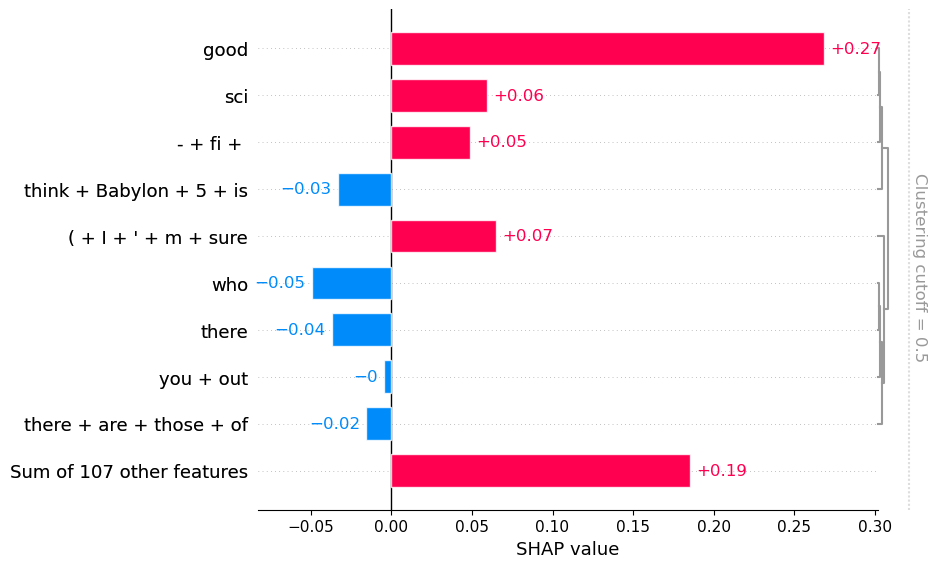

In [ ]:
shap.plots.bar(shap_values[0,:,"POSITIVE"])

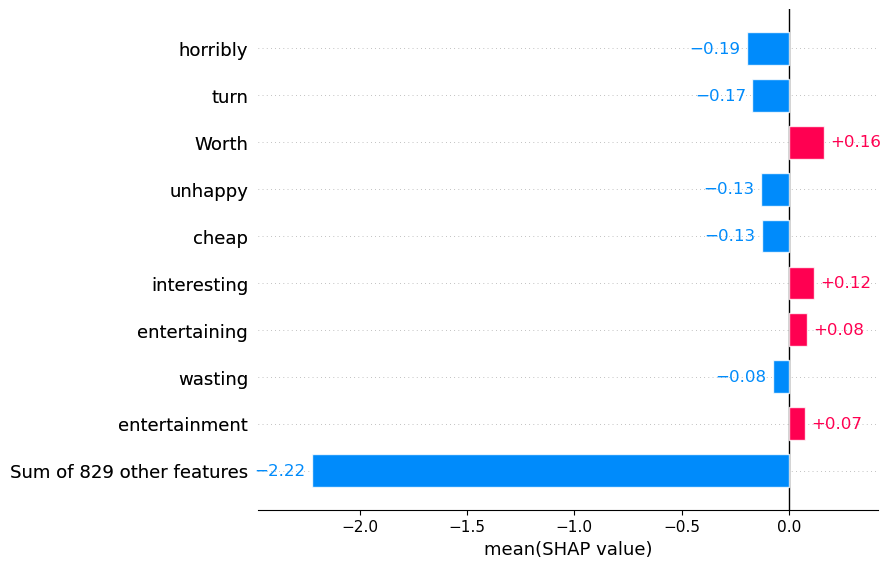

In [ ]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0))

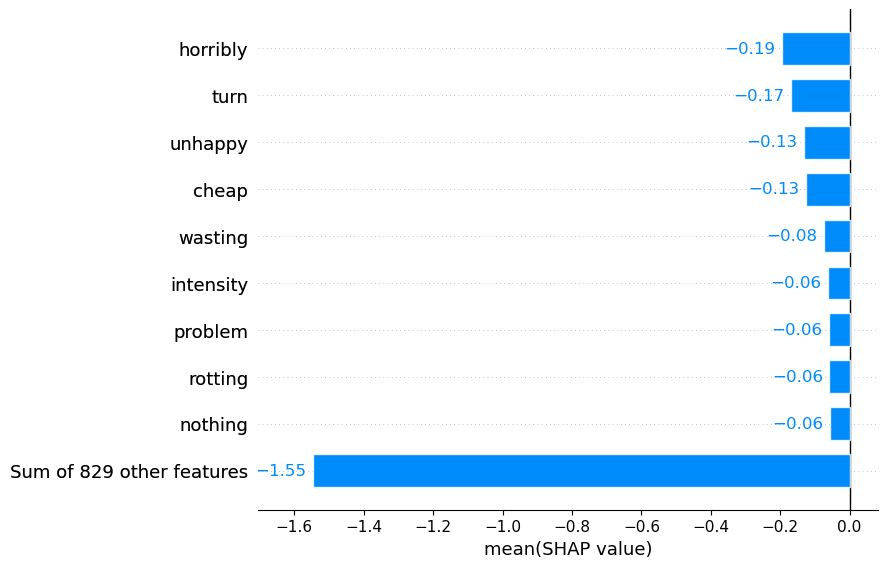

In [ ]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0), order=shap.Explanation.argsort)